In [1]:
#librerias
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")


# Unique Visitors

## Carga y Preparación Datos

In [2]:
path='../data/raw/web.csv'
df_web=pd.read_csv(path)
df_web.head()

,ID_Date,Unique_visitors,PDFBrochuresDownloaded,ProductConfigurator,Product_configurator_Visists,SocialNetworks,DirectTraffic,EMail,NaturalSearch,OnlineMedia,OtherReferrer,PaidSearch
0,202201,272382,4838,33222,94248,1415,65373,25,167199,63649,39808,13798
1,202202,352581,5823,38570,109531,546,77209,26,176733,124861,45543,28656
2,202203,332955,4845,33956,97805,5444,83178,341,173514,104132,43583,15243
3,202204,282169,3711,45949,90689,1184,69335,162,162805,74044,39650,18510
4,202205,261829,9037,48685,92069,8648,70972,210,156011,44196,40472,20031


**Información Columnas**



| Columna                        | Descripción procedencia                                      |
|-------------------------------|--------------------------------------------------------------------------------|
| `ID_Date`                     | Fecha usada para ordenar la serie temporal |
| `Unique_visitors`             | Número total de visitantes únicos a la web (variable objetivo)                |
| `PDFBrochuresDownloaded`      | Número de folletos PDF descargados por los usuarios    |
| `ProductConfigurator`         | Número de usos del configurador de producto en la web                         |
| `Product_configurator_Visists`| Número de visitas al configurador de producto                                 |
| `SocialNetworks`              | Tráfico desde redes sociales                                  |
| `DirectTraffic`               | Tráfico directo: usuarios que escriben la URL            |
| `EMail`                       | Tráfico desde campañas de correo electrónico                                  |
| `NaturalSearch`               | Tráfico orgánico desde buscadores como Google (SEO)                           |
| `OnlineMedia`                 | Tráfico desde medios online de pago  |
| `OtherReferrer`              |  Tráfico desde otras fuentes no categorizadas                                  |
| `PaidSearch`                  | Tráfico desde campañas de búsqueda pagada   |


### Transfomación de la Columna Date

Preparamos la columna `ID_Date` convirtiéndola en fechas mensuales, la usamos como índice temporal, ordenamos los datos y dejamos la serie lista para análisis mensual.


In [3]:
# Convertir ID_Date (tipo 202201) en una fecha real: 2022-01-01
df_web['Fecha'] = pd.to_datetime(df_web['ID_Date'].astype(str), format='%Y%m')

# Establecer Fecha como índice y ordenar
df_web.set_index('Fecha', inplace=True)
df_web.sort_index(inplace=True)

# Indicar que es una serie mensual
df_web = df_web.asfreq('MS')

# Para que no salga la hora
df_web.index = df_web.index.to_period('M')


In [44]:
df_web.head()

,ID_Date,Unique_visitors,PDFBrochuresDownloaded,ProductConfigurator,Product_configurator_Visists,SocialNetworks,DirectTraffic,EMail,NaturalSearch,OnlineMedia,OtherReferrer,PaidSearch
Fecha,,,,,,,,,,,,
2022-01,202201,272382,4838,33222,94248,1415,65373,25,167199,63649,39808,13798
2022-02,202202,352581,5823,38570,109531,546,77209,26,176733,124861,45543,28656
2022-03,202203,332955,4845,33956,97805,5444,83178,341,173514,104132,43583,15243
2022-04,202204,282169,3711,45949,90689,1184,69335,162,162805,74044,39650,18510
2022-05,202205,261829,9037,48685,92069,8648,70972,210,156011,44196,40472,20031


## Serie Unique Visitors

A continuación, observamos cómo se comporta la variable objetivo `Unique_visitors`, que queremos predecir. Para ello, graficamos su evolución mensual en el tiempo:

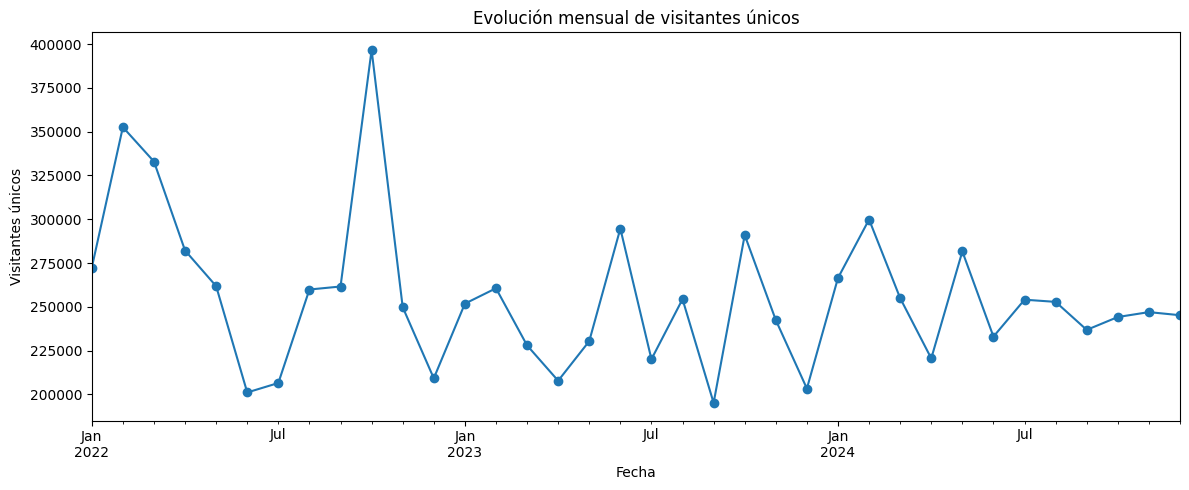

In [4]:
plt.figure(figsize=(12, 5))
df_web['Unique_visitors'].plot(marker='o', linestyle='-')
plt.title('Evolución mensual de visitantes únicos')
plt.xlabel('Fecha')
plt.ylabel('Visitantes únicos')
plt.tight_layout()
plt.show()


**Observaciones clave sobre la serie `Unique_visitors`**

- Picos de tráfico:
  - Se observan valores máximos especialmente en febrero de 2022 y septiembre de 2022.
  - También se registran aumentos destacados en enero de algunos años.

- Caídas pronunciadas:
  - El tráfico disminuye notablemente tras los picos.
  - En diciembre se detecta una caída recurrente del número de visitantes.

- **Estacionalidad**:
  - En enero suele haber una recuperación tras la bajada de diciembre.
  - Septiembre y octubre presentan subidas recurrentes que podrían asociarse a campañas o reinicio de actividad tras verano.

- **Tendencia general**:
  - A lo largo del periodo analizado, se observa una ligera tendencia descendente en el volumen de visitantes.
  - En los últimos meses, el comportamiento de la serie se muestra más estable.

### Descomposicón Serie

Se realiza la descomposición de la serie utilizando un modelo aditivo. Este tipo de modelo se aplica cuando se considera que la serie es el resultado de la suma de sus tres componentes principales:

- Serie original = Tendencia + Estacionalidad + Ruido

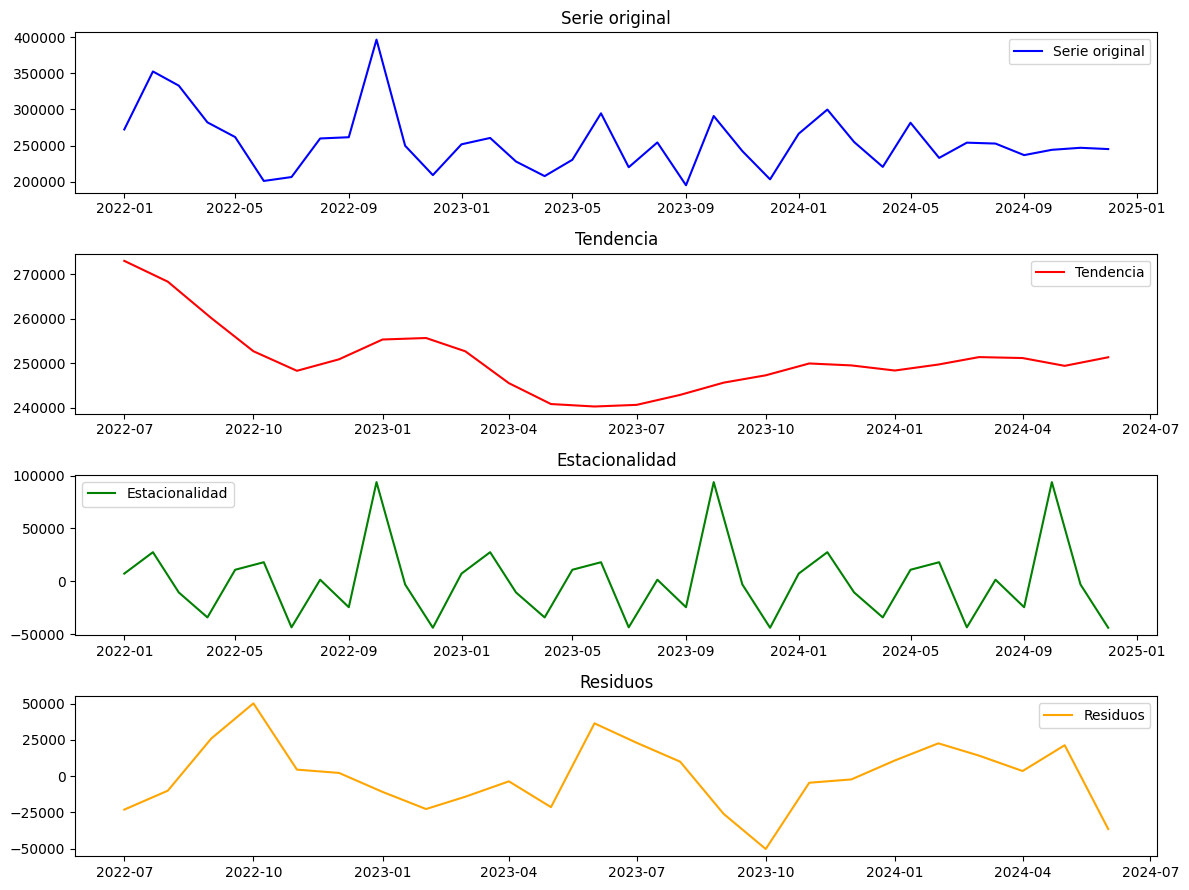

In [5]:
df_web.index = df_web.index.to_timestamp()
serie = df_web['Unique_visitors']

# Descomposición aditiva 
decomposition = seasonal_decompose(serie, model='additive', period=12) #periodo de 12 meses
# Tendencia/Estacionalidad
tendencia = decomposition.trend
estacionalidad = decomposition.seasonal
residuos = decomposition.resid

# Graficar la serie original y las tres componentes
plt.figure(figsize=(12, 9))

plt.subplot(411)
plt.plot(serie, label='Serie original', color='blue')
plt.title('Serie original')
plt.legend()

plt.subplot(412)
plt.plot(tendencia, label='Tendencia', color='red')
plt.title('Tendencia')
plt.legend()

plt.subplot(413)
plt.plot(estacionalidad, label='Estacionalidad', color='green')
plt.title('Estacionalidad')
plt.legend()

plt.subplot(414)
plt.plot(residuos, label='Residuos', color='orange')
plt.title('Residuos')
plt.legend()

plt.tight_layout()
plt.show()


**Descomposición Serie**

- Tendencia: Presenta una caída progresiva desde mediados de 2022 hasta mediados de 2023, seguida de una ligera recuperación y estabilización en 2024.

- Estacionalidad: Se detectan patrones que se repiten a lo largo del tiempo, con subidas y bajadas cíclicas, lo que confirma la presencia de estacionalidad anual.

- Residuos: No muestran una estructura clara, lo cual es positivo, ya que indica que la mayor parte de la variación ha sido explicada por la tendencia.

### Coeficientes Serie

**Justificación inicial de parámetros SARIMA**

- `d = 1` 
  Vemos claramente una tendencia descendente en la serie.  
  Para eliminarla, parte diferencial del modelo.

- `D = 1`, `s = 12`
  Observamos que se repiten los mismos patrones cada año, especialmente los picos en octubre y las caídas en enero.  
  Esto indica estacionalidad anual, así que usamos `D = 1` para eliminarla y `s = 12` porque trabajamos con datos mensuales.

- `q`, `Q` (componentes de errores) 
  Los residuos tienen ciertas oscilaciones, pero no es clara su estructura.  
  Por tanto, vamos a probar con distintos valores (`q = 0` o `1`, `Q = 0` o `1`) y elegir los que mejor se ajusten.

- `p`, `P` (componentes autoregresivos) 
  Aún no sabemos si los valores anteriores afectan directamente a los actuales.  
  Para decidirlo, vamos a usar los gráficos *ACF y PACF*, que nos dirán si existe esa relación.


### ACF Y PACF

¿Para qué sirven estos parámetros?

- **ACF**
  - Mide la correlación entre un valor y sus valores pasados.
  - Nos ayuda a elegir el parámetro `q` (parte MA = media móvil).

- **PACF**
  - Mide la correlación directa entre un valor y sus valores pasados, quitando los lags intermedios.
  - Nos ayuda a elegir el parámetro `p`(parte AR = autoregresiva).

**Gráfico ACF**

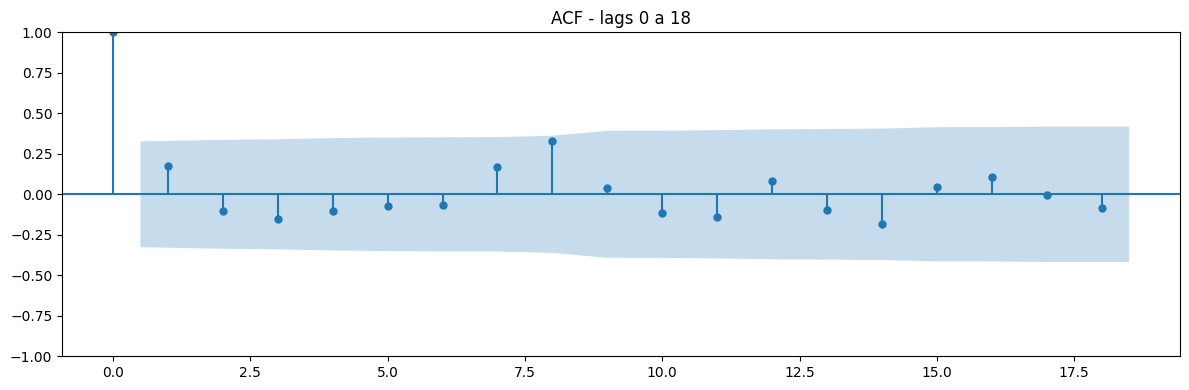

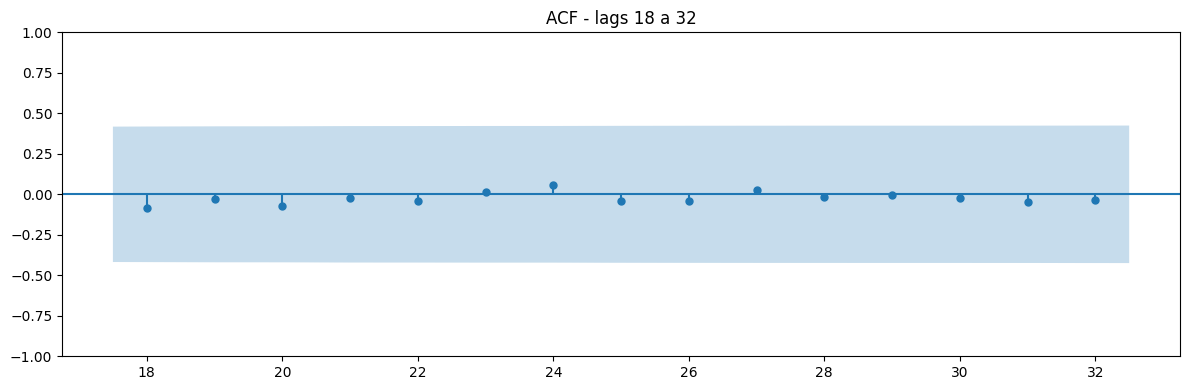

In [6]:
#Gráficos ACF (0-18 y 18-32)

fig, ax1 = plt.subplots(figsize=(12, 4))
plot_acf(serie, lags=18, ax=ax1)
ax1.set_title('ACF - lags 0 a 18')
plt.tight_layout()
plt.show()


fig, ax2 = plt.subplots(figsize=(12, 4))
plot_acf(serie, lags=range(18, 33), ax=ax2)
ax2.set_title('ACF - lags 18 a 32')
plt.tight_layout()
plt.show()

**Gráfico PACF**

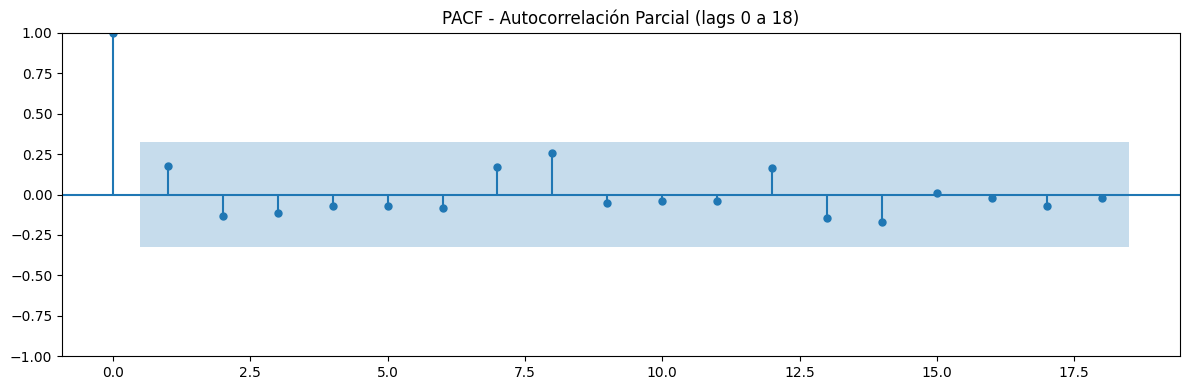

In [7]:
# PACF  (0 - 18)
fig, ax = plt.subplots(figsize=(12, 4))
plot_pacf(serie, lags=18, ax=ax, method='ywm')
ax.set_title('PACF - Autocorrelación Parcial (lags 0 a 18)')
plt.tight_layout()
plt.show()

Párametros `p`y `q`

- *Parte autoregresiva (AR)* → `p = 8`  
  Porque el primer pico significativo de la PACF aparece en el **lag 8**, lo que sugiere una fuerte relación directa con el valor de hace 8 meses.

- *Parte de media móvil (MA)* → `q = 0` y `q = 1`  
  Vamos a probar ambos, ya que en el gráfico ACF no se observan muchos picos significativos. 

# Sarima Unique Visitors

**División Train-Test**

In [8]:
serie_temporal = df_web['Unique_visitors']

# División 80/20
train_size = int(len(serie_temporal) * 0.8)
train = serie_temporal[:train_size]
test = serie_temporal[train_size:]

**Iteración Parámetros**

In [9]:
from pmdarima import auto_arima

modelo = auto_arima(train,
                   seasonal=True,
                   m=12,  
                   start_p=0,
                   start_q=0,
                   start_P=0,
                   start_Q=0,
                   d=1,
                   D=1,
                   max_p=3,
                   max_q=3,
                   max_P=2,
                   max_Q=2,
                   max_d=2,
                   max_D=1,
                   max_order=8,
                   stepwise=False,  # búsqueda exhaustiva
                   trace=True,
                   scoring='mae',
                   suppress_warnings=True)

print("Mejores hiperparámetros SARIMA:", modelo.get_params())

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=375.300, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=367.872, Time=0.02 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=369.479, Time=0.04 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=368.040, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=369.858, Time=0.02 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=371.430, Time=0.11 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=370.067, Time=0.03 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=371.599, Time=0.06 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=373.181, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=373.877, Time=0.01 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=371.145, Time=0.02 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=373.111, Time=0.04 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=371.857, Time=0.01 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=373.117, Time=0.03 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=375.073, Time=0.15 sec
 ARIMA(0,1

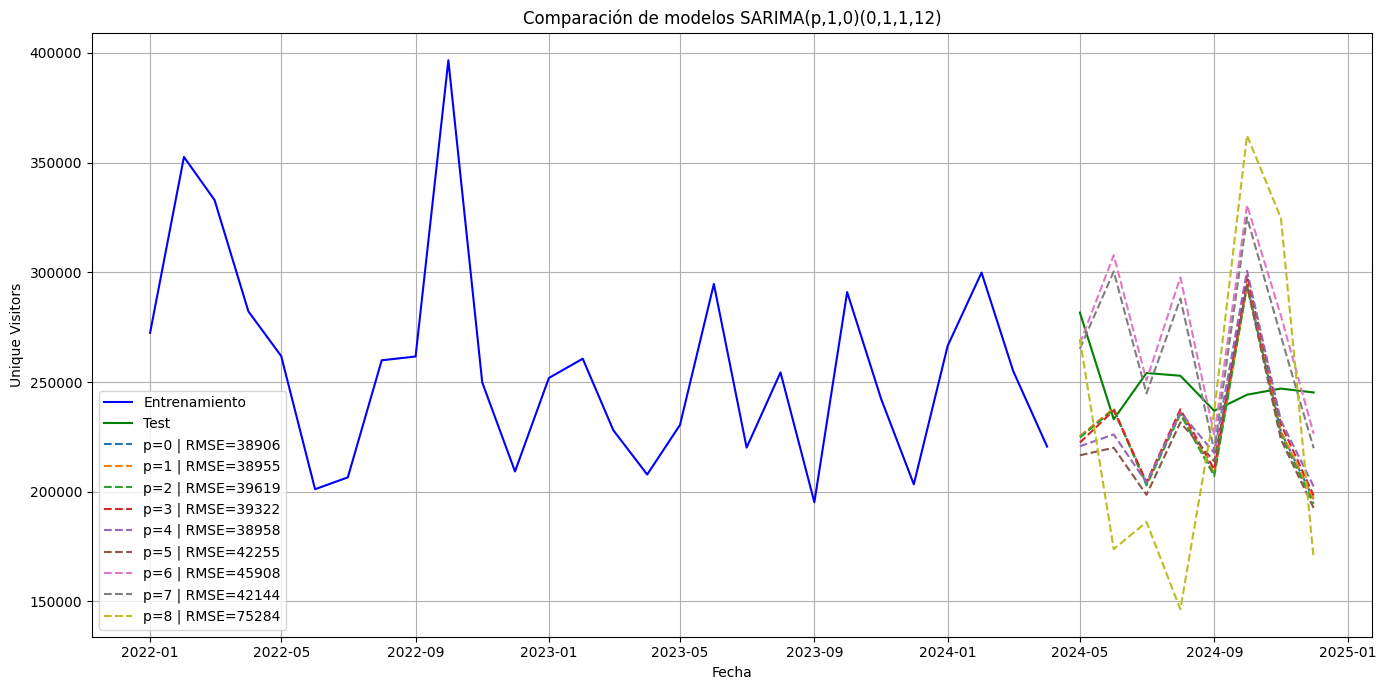


 Resultados ordenados por AIC:
 p     order          AIC          MAE         RMSE         R2
 0 (0, 1, 0) 3.678725e+02 34394.379175 38906.271672  -6.814321
 1 (1, 1, 0) 3.699958e+02 34466.633094 38955.081303  -6.833940
 4 (4, 1, 0) 3.722639e+02 33447.278716 38957.637183  -6.834968
 2 (2, 1, 0) 3.723971e+02 35172.166307 39619.124544  -7.103297
 7 (7, 1, 0) 3.732284e+02 34572.097396 42143.588005  -8.168853
 3 (3, 1, 0) 3.738122e+02 34064.069995 39321.698727  -6.982088
 5 (5, 1, 0) 3.752537e+02 37971.139247 42254.830589  -8.217321
 6 (6, 1, 0) 3.765961e+02 35832.759952 45907.720938  -9.879864
 8 (8, 1, 0) 1.710533e+06 64673.397622 75283.546590 -28.258505


In [10]:
# Metricas por serie
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

resultados_modelos = []

# Dibujar la serie real
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Entrenamiento', color='blue')
plt.plot(test.index, test, label='Test', color='green')

# Probamos con varias series autoregresivas desde p = 0 hasta 8
for p in range(9):
    try:
        model = SARIMAX(train, order=(p, 1, 0), seasonal_order=(0, 1, 1, 12))
        fit = model.fit(disp=False)
        pred = fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')
        mse, mae, rmse, r2 = calcular_metricas(test, pred)
        aic = fit.aic

        # Guardar resultados
        resultados_modelos.append({
            'p': p,
            'order': (p, 1, 0),
            'seasonal_order': (0, 1, 1, 12),
            'AIC': aic,
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2
        })

        # Dibujar la predicción
        plt.plot(test.index, pred, linestyle='--', label=f'p={p} | RMSE={rmse:.0f}')
    except Exception as e:
        print(f" Error en modelo SARIMA({p},1,0)(0,1,1,12): {e}")

# Gráfico final
plt.title('Comparación de modelos SARIMA(p,1,0)(0,1,1,12)')
plt.xlabel('Fecha')
plt.ylabel('Unique Visitors')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Mostrar resultados ordenados por AIC
df_resultados = pd.DataFrame(resultados_modelos).sort_values(by='AIC')
print("\n Resultados ordenados por AIC:")
print(df_resultados[['p', 'order', 'AIC', 'MAE', 'RMSE', 'R2']].to_string(index=False))

**Autoregresivo de Orden 4 / p=4**

 Métricas del modelo SARIMA (4,1,0)(0,1,1,12):
MSE:  1,517,697,494.90
MAE:  33,447.28
RMSE: 38,957.64
R²:   -6.8350

 AIC del modelo: 372.26385779418615
 BIC del modelo: 376.5121590007994


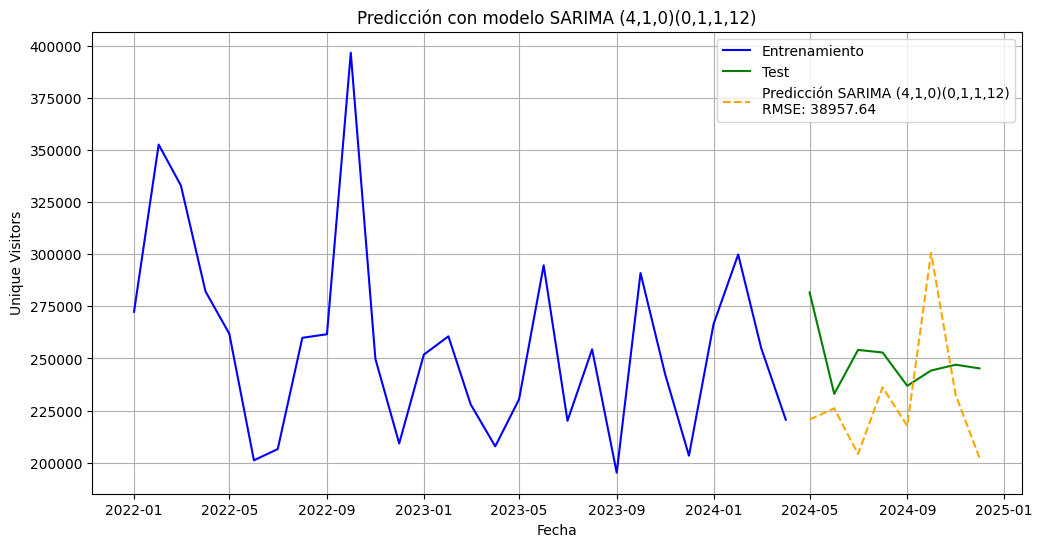

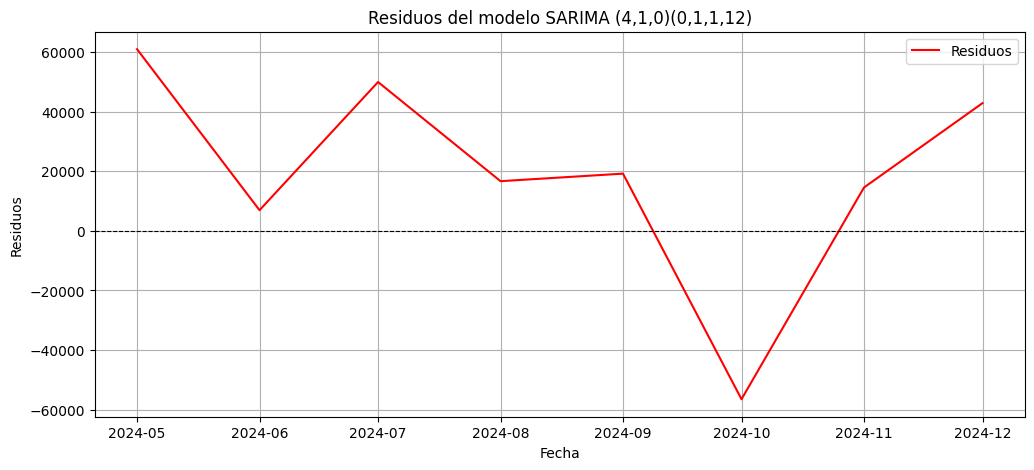

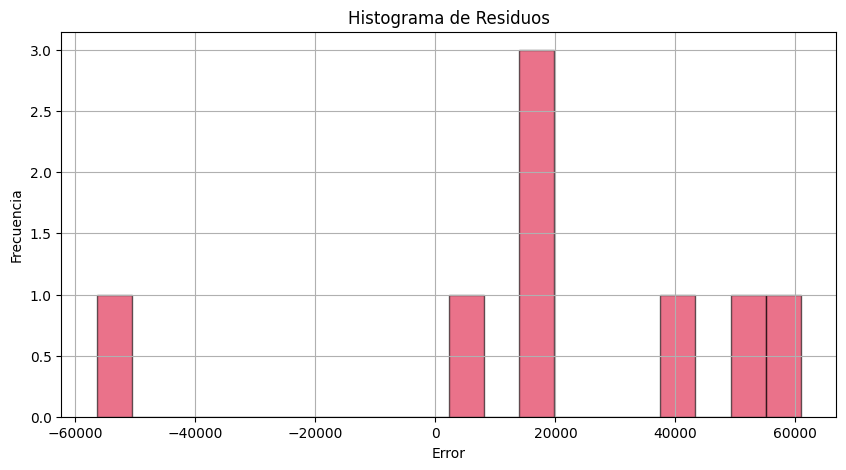


 Coeficientes del modelo SARIMA (4,1,0)(0,1,1,12):
                                      SARIMAX Results                                       
Dep. Variable:                      Unique_visitors   No. Observations:                   28
Model:             SARIMAX(4, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -180.132
Date:                              Mon, 14 Apr 2025   AIC                            372.264
Time:                                      08:57:47   BIC                            376.512
Sample:                                  01-01-2022   HQIC                           372.219
                                       - 04-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0032      0.276     -0.012   

In [11]:
sarima_model = SARIMAX(train, order=(4, 1, 0), seasonal_order=(0, 1, 1, 12))
sarima_fit = sarima_model.fit()
sarima_predictions = sarima_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

# Calcular métricas
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

metricas = calcular_metricas(test, sarima_predictions)
print(" Métricas del modelo SARIMA (4,1,0)(0,1,1,12):")
print(f"MSE:  {metricas[0]:,.2f}")
print(f"MAE:  {metricas[1]:,.2f}")
print(f"RMSE: {metricas[2]:,.2f}")
print(f"R²:   {metricas[3]:.4f}")

# AIC y BIC
print("\n AIC del modelo:", sarima_fit.aic)
print(" BIC del modelo:", sarima_fit.bic)

# Graficar predicciones
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entrenamiento', color='blue')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(test.index, sarima_predictions, linestyle='--', label=f'Predicción SARIMA (4,1,0)(0,1,1,12)\nRMSE: {metricas[2]:.2f}', color='orange')
plt.xlabel('Fecha')
plt.ylabel('Unique Visitors')
plt.title('Predicción con modelo SARIMA (4,1,0)(0,1,1,12)')
plt.legend()
plt.grid(True)
plt.show()

# Residuos
residuos = test - sarima_predictions

# Gráfico de residuos
plt.figure(figsize=(12, 5))
plt.plot(test.index, residuos, label='Residuos', color='red')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel('Fecha')
plt.ylabel('Residuos')
plt.title('Residuos del modelo SARIMA (4,1,0)(0,1,1,12)')
plt.legend()
plt.grid(True)
plt.show()

# Histograma de residuos
plt.figure(figsize=(10, 5))
plt.hist(residuos, bins=20, color='crimson', edgecolor='black', alpha=0.6)
plt.title('Histograma de Residuos')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Coeficientes del modelo
print("\n Coeficientes del modelo SARIMA (4,1,0)(0,1,1,12):")
print(sarima_fit.summary())

**Conclusión**: Seleccionamos SARIMA(4,1,0)(0,1,1,12) por su mejor comportamiento en términos de error absoluto y distribución de residuos.

**Autorgresivo de Orden 1 / p=1**

 Métricas del modelo SARIMA (1,1,0)(0,1,1,12):
MSE:  1,517,498,359.30
MAE:  34,466.63
RMSE: 38,955.08
R²:   -6.8339

 AIC del modelo: 369.9957789819673
 BIC del modelo: 372.11992958527395


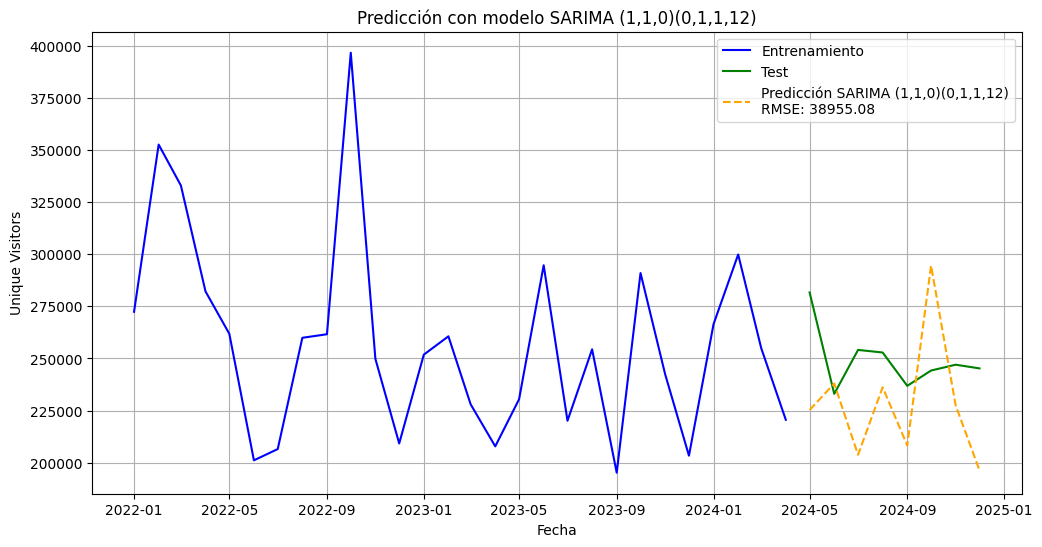

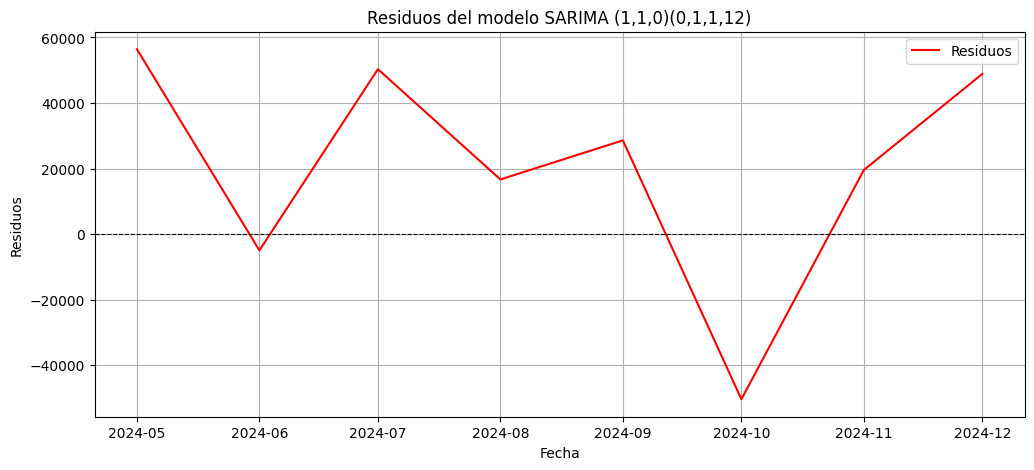

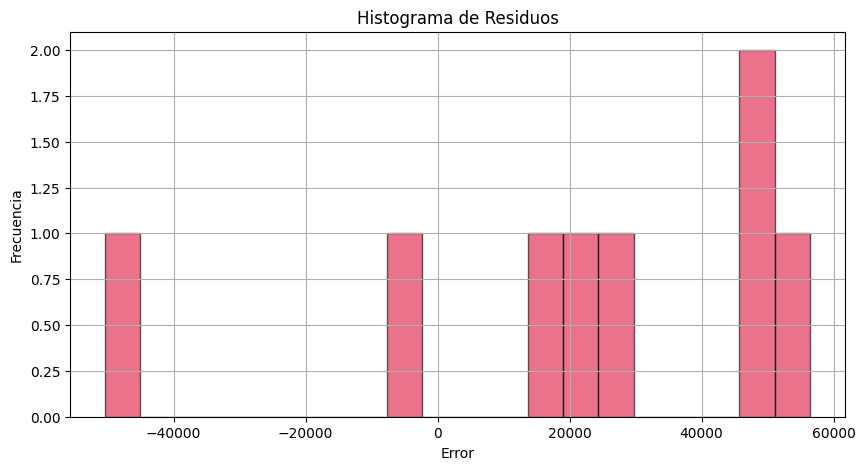


 Coeficientes del modelo SARIMA (1,1,0)(0,1,1,12):
                                      SARIMAX Results                                       
Dep. Variable:                      Unique_visitors   No. Observations:                   28
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -181.998
Date:                              Mon, 14 Apr 2025   AIC                            369.996
Time:                                      08:57:55   BIC                            372.120
Sample:                                  01-01-2022   HQIC                           369.973
                                       - 04-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0105      0.342      0.031   

In [12]:
sarima_model = SARIMAX(train, order=(1, 1, 0), seasonal_order=(0, 1, 1, 12))
sarima_fit = sarima_model.fit()
sarima_predictions = sarima_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

# Calcular métricas
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

metricas = calcular_metricas(test, sarima_predictions)
print(" Métricas del modelo SARIMA (1,1,0)(0,1,1,12):")
print(f"MSE:  {metricas[0]:,.2f}")
print(f"MAE:  {metricas[1]:,.2f}")
print(f"RMSE: {metricas[2]:,.2f}")
print(f"R²:   {metricas[3]:.4f}")

# AIC y BIC
print("\n AIC del modelo:", sarima_fit.aic)
print(" BIC del modelo:", sarima_fit.bic)

# Graficar predicciones
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entrenamiento', color='blue')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(test.index, sarima_predictions, linestyle='--', label=f'Predicción SARIMA (1,1,0)(0,1,1,12)\nRMSE: {metricas[2]:.2f}', color='orange')
plt.xlabel('Fecha')
plt.ylabel('Unique Visitors')
plt.title('Predicción con modelo SARIMA (1,1,0)(0,1,1,12)')
plt.legend()
plt.grid(True)
plt.show()

# Residuos
residuos = test - sarima_predictions

# Gráfico de residuos
plt.figure(figsize=(12, 5))
plt.plot(test.index, residuos, label='Residuos', color='red')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel('Fecha')
plt.ylabel('Residuos')
plt.title('Residuos del modelo SARIMA (1,1,0)(0,1,1,12)')
plt.legend()
plt.grid(True)
plt.show()

# Histograma de residuos
plt.figure(figsize=(10, 5))
plt.hist(residuos, bins=20, color='crimson', edgecolor='black', alpha=0.6)
plt.title('Histograma de Residuos')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Coeficientes del modelo
print("\n Coeficientes del modelo SARIMA (1,1,0)(0,1,1,12):")
print(sarima_fit.summary())

## PRUEBA 

 Métricas del modelo SARIMA (1,1,0)(0,1,1,12):
MSE:  739,851,228.64
MAE:  21,910.79
RMSE: 27,200.21
R²:   -2.8194

 AIC del modelo: 703.6212243479727
 BIC del modelo: 715.6110649395495


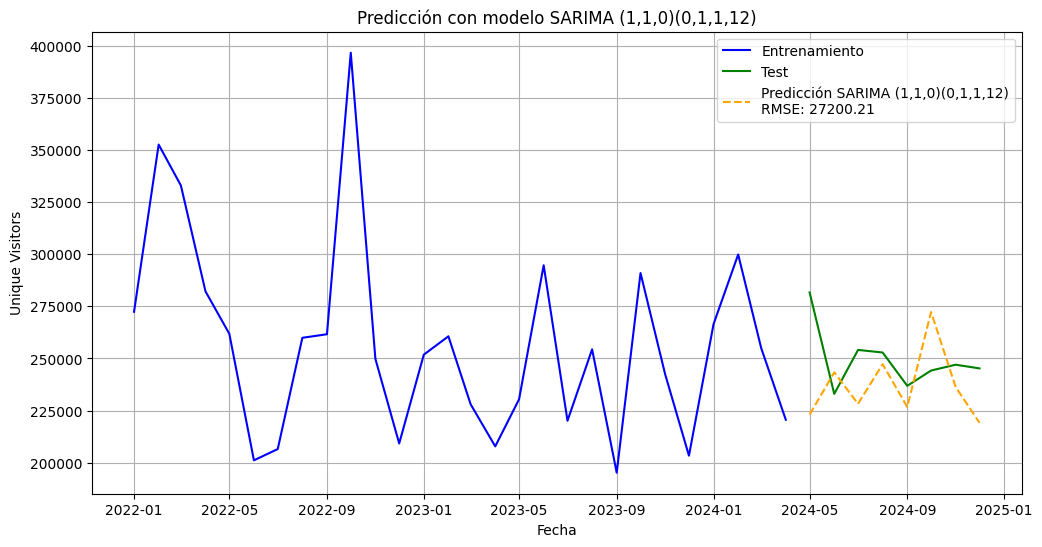

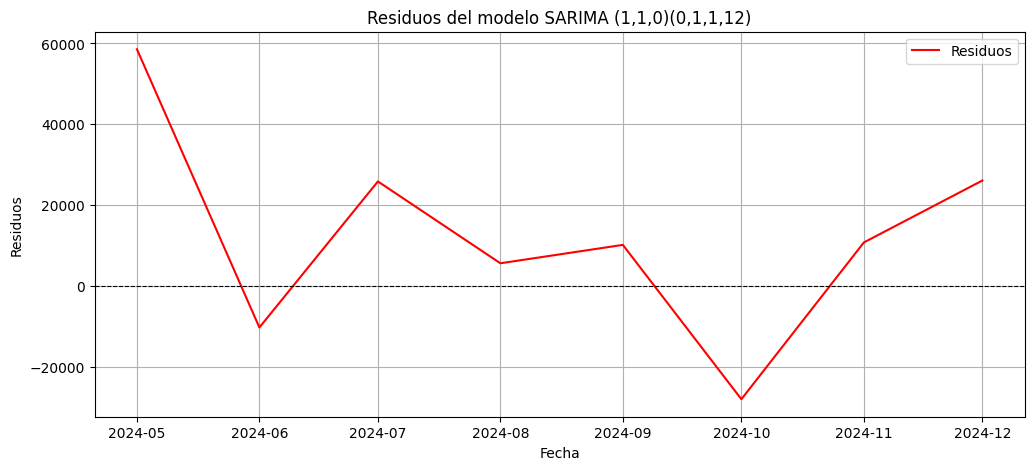

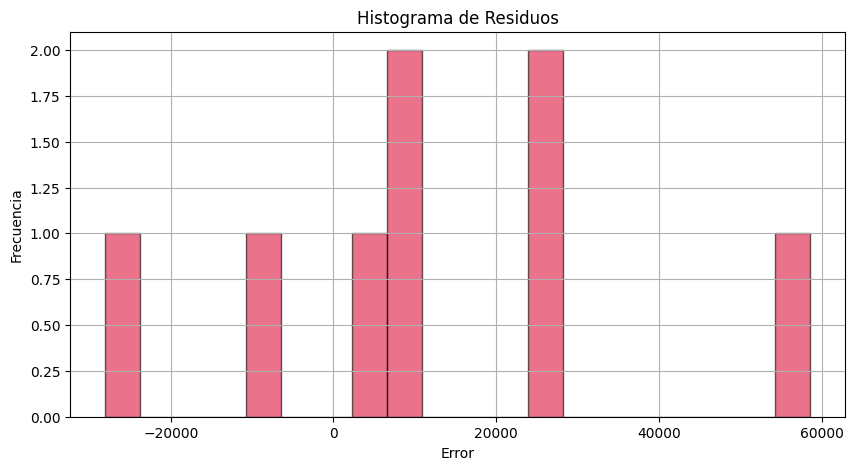


 Coeficientes del modelo SARIMA (1,1,0)(0,1,1,12):
                                        SARIMAX Results                                        
Dep. Variable:                         Unique_visitors   No. Observations:                   28
Model:             SARIMAX(4, 0, 1)x(1, 0, [1, 2], 12)   Log Likelihood                -342.811
Date:                                 Mon, 14 Apr 2025   AIC                            703.621
Time:                                         09:01:07   BIC                            715.611
Sample:                                     01-01-2022   HQIC                           707.287
                                          - 04-01-2024                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2656 

In [21]:
sarima_model = SARIMAX(train, order=(4, 0, 1), seasonal_order=(1, 0, 2, 12))
sarima_fit = sarima_model.fit()
sarima_predictions = sarima_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

# Calcular métricas
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

metricas = calcular_metricas(test, sarima_predictions)
print(" Métricas del modelo SARIMA (1,1,0)(0,1,1,12):")
print(f"MSE:  {metricas[0]:,.2f}")
print(f"MAE:  {metricas[1]:,.2f}")
print(f"RMSE: {metricas[2]:,.2f}")
print(f"R²:   {metricas[3]:.4f}")

# AIC y BIC
print("\n AIC del modelo:", sarima_fit.aic)
print(" BIC del modelo:", sarima_fit.bic)

# Graficar predicciones
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entrenamiento', color='blue')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(test.index, sarima_predictions, linestyle='--', label=f'Predicción SARIMA (1,1,0)(0,1,1,12)\nRMSE: {metricas[2]:.2f}', color='orange')
plt.xlabel('Fecha')
plt.ylabel('Unique Visitors')
plt.title('Predicción con modelo SARIMA (1,1,0)(0,1,1,12)')
plt.legend()
plt.grid(True)
plt.show()

# Residuos
residuos = test - sarima_predictions

# Gráfico de residuos
plt.figure(figsize=(12, 5))
plt.plot(test.index, residuos, label='Residuos', color='red')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel('Fecha')
plt.ylabel('Residuos')
plt.title('Residuos del modelo SARIMA (1,1,0)(0,1,1,12)')
plt.legend()
plt.grid(True)
plt.show()

# Histograma de residuos
plt.figure(figsize=(10, 5))
plt.hist(residuos, bins=20, color='crimson', edgecolor='black', alpha=0.6)
plt.title('Histograma de Residuos')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Coeficientes del modelo
print("\n Coeficientes del modelo SARIMA (1,1,0)(0,1,1,12):")
print(sarima_fit.summary())

## Selección Final SARIMA


Se ha realizado una comparación entre distintos modelos SARIMA aplicados a la serie temporal, manteniendo fija la parte estacional (0,1,1,12) y variando el orden p. 

Tras probar distintos valores, se seleccionaron los modelos con p=1 y p=4 para una comparación más detallada.


| Modelo | Orden SARIMA           | AIC    | BIC    | MAE      | RMSE    | R²       |
|--------|------------------------|--------|--------|----------|---------|----------|
| 1      | (4,1,0)(0,1,1,12)      | 372.26 | 376.51 | 33,447   | 38,957  | -6.8350  |
| 2      | (1,1,0)(0,1,1,12)      | 369.99 | 372.12 | 34,466   | 38,955  | -6.8339  |

Aunque el modelo con orden 1 tiene un AIC y BIC ligeramente mejores, se ha seleccionado el modelo con orden 4 por los siguientes motivos:

- Tiene un menor MAE, por lo que el error medio absoluto de las predicciones es menor.
- La distribución de residuos es más centrada, con menos errores extremos negativos.
- A pesar de la ligera diferencia en AIC y BIC, el modelo con orden 4 ofrece mayor estabilidad.



**SARIMA (4,1,0)(0,1,1,12)**

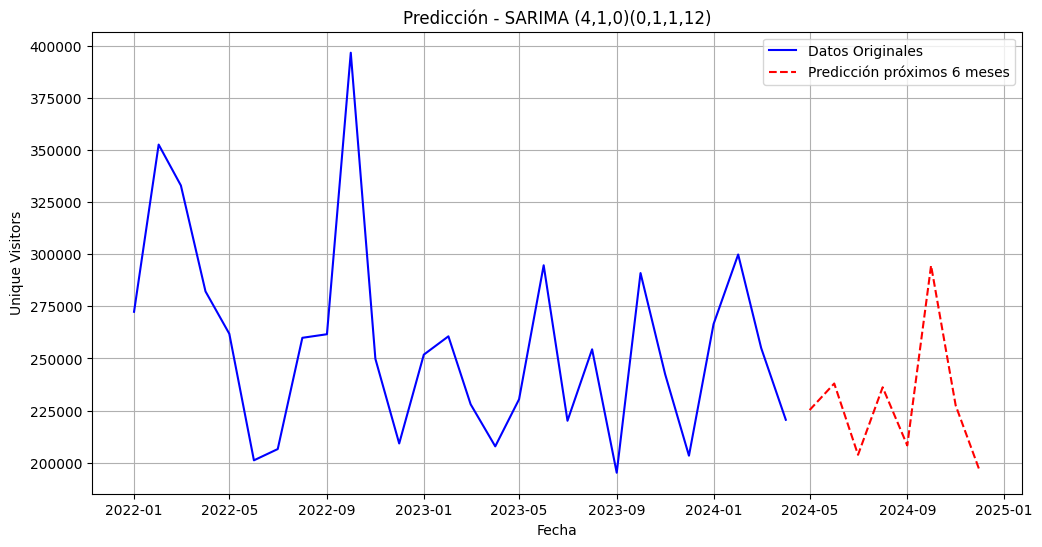

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Datos Originales', color='blue')
plt.plot(test.index, sarima_predictions, label='Predicción próximos 6 meses', color='red', linestyle='--')

plt.xlabel('Fecha')
plt.ylabel('Unique Visitors')
plt.title('Predicción - SARIMA (4,1,0)(0,1,1,12)')
plt.legend()
plt.grid(True)
plt.show()

## SUCIO

**Linea base desde último dato**

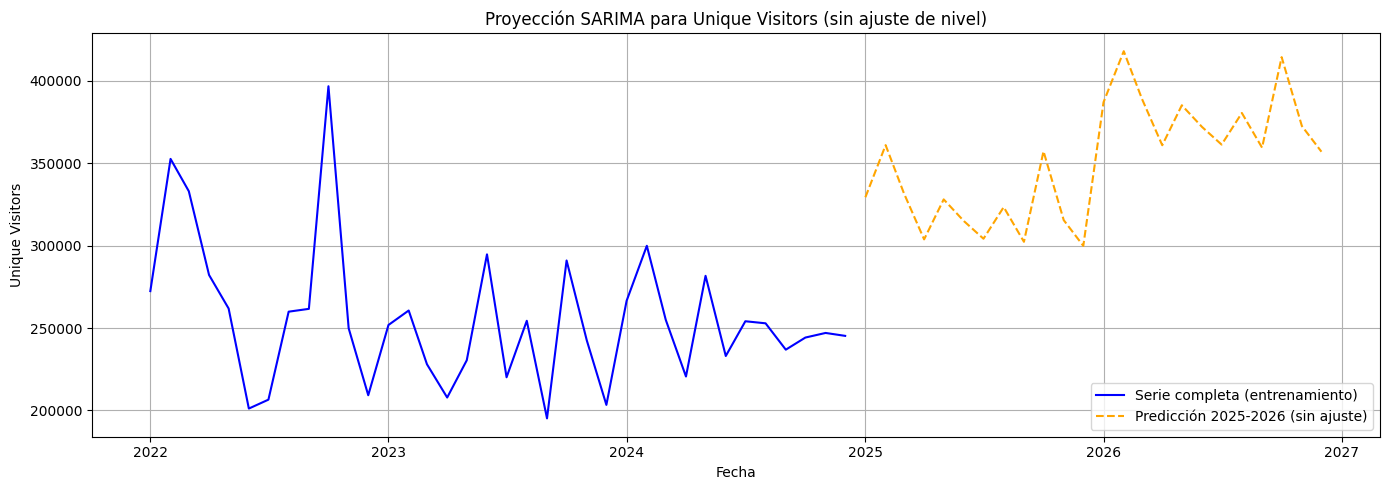

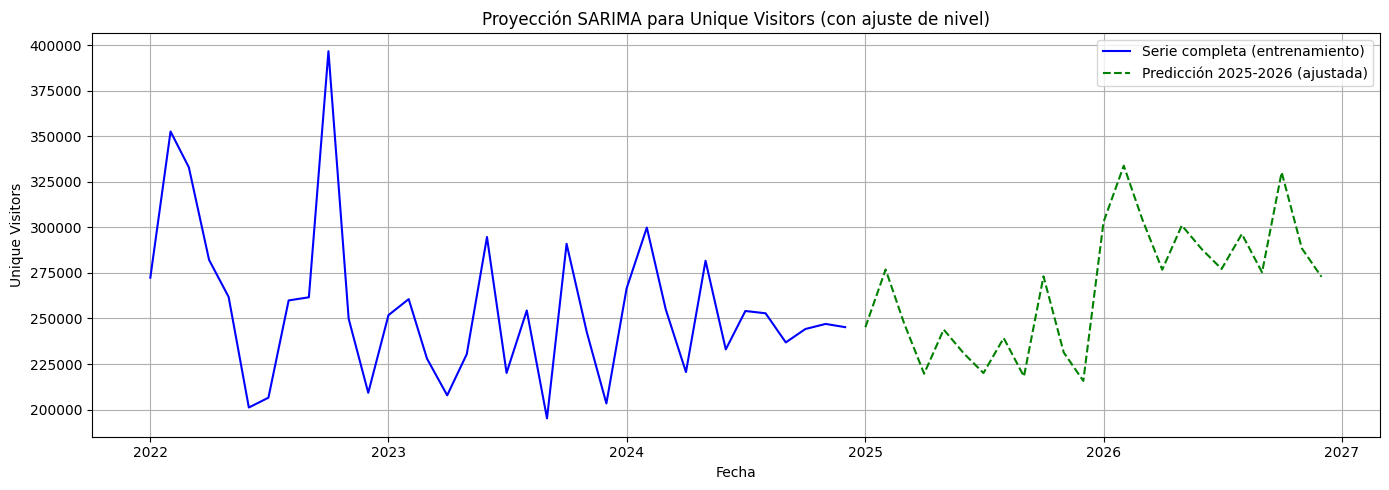

In [55]:
# Suponemos que df_web ya tiene un índice datetime y la columna 'Unique_visitors'
serie_completa = df_web['Unique_visitors']

# ENTRENAR SARIMA CON TODA LA SERIE (usa los hiperparámetros que encontraste antes)
modelo_full = SARIMAX(serie_completa, order=(1, 1, 0), seasonal_order=(0, 1, 1, 12))
sarima_fit_full = modelo_full.fit()

# PREDECIR PARA 2025 Y 2026 (24 meses)
forecast_horizon = 24
pred_2025_2026 = sarima_fit_full.predict(
    start=len(serie_completa),
    end=len(serie_completa) + forecast_horizon - 1,
    typ='levels'
)

# Crear índice de fechas para las predicciones
last_date = serie_completa.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS')
pred_2025_2026.index = future_dates

# OPCIÓN 1: Gráfico sin ajuste
plt.figure(figsize=(14, 5))
plt.plot(serie_completa, label='Serie completa (entrenamiento)', color='blue')
plt.plot(pred_2025_2026, linestyle='--', color='orange', label='Predicción 2025-2026 (sin ajuste)')
plt.title('Proyección SARIMA para Unique Visitors (sin ajuste de nivel)')
plt.xlabel('Fecha')
plt.ylabel('Unique Visitors')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# OPCIÓN 2: Gráfico con ajuste de nivel
ajuste = serie_completa.iloc[-1] - pred_2025_2026.iloc[0]
pred_ajustada = pred_2025_2026 + ajuste

plt.figure(figsize=(14, 5))
plt.plot(serie_completa, label='Serie completa (entrenamiento)', color='blue')
plt.plot(pred_ajustada, linestyle='--', color='green', label='Predicción 2025-2026 (ajustada)')
plt.title('Proyección SARIMA para Unique Visitors (con ajuste de nivel)')
plt.xlabel('Fecha')
plt.ylabel('Unique Visitors')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [56]:
# MOSTRAR AIC y BIC
print("AIC del modelo final:", sarima_fit_full.aic)
print("BIC del modelo final:", sarima_fit_full.bic)

AIC del modelo final: 566.3636255849328
BIC del modelo final: 569.7701082327203


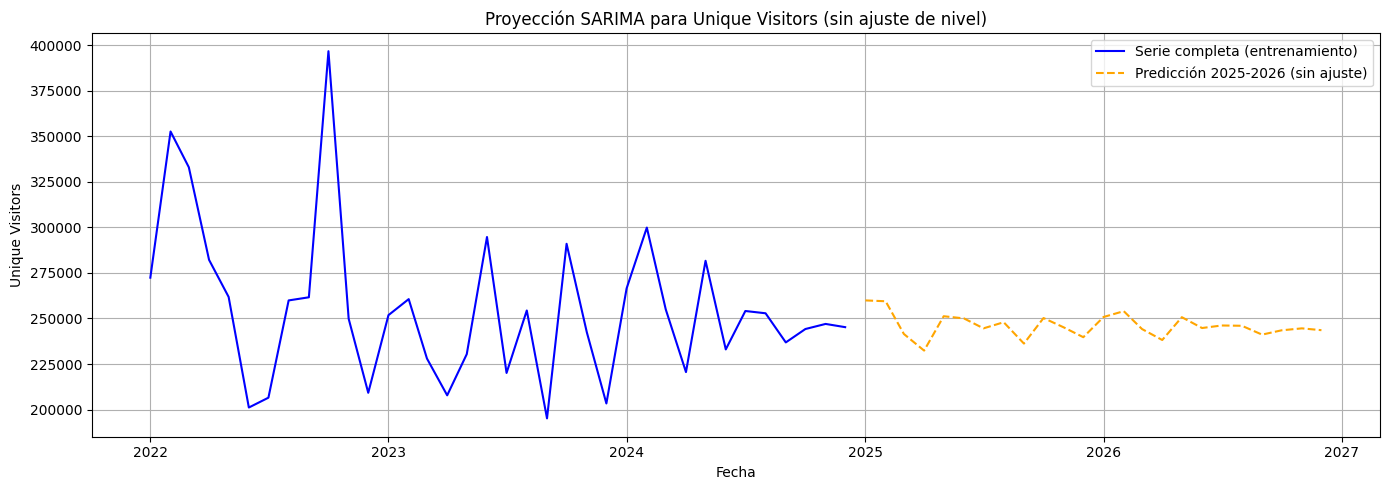

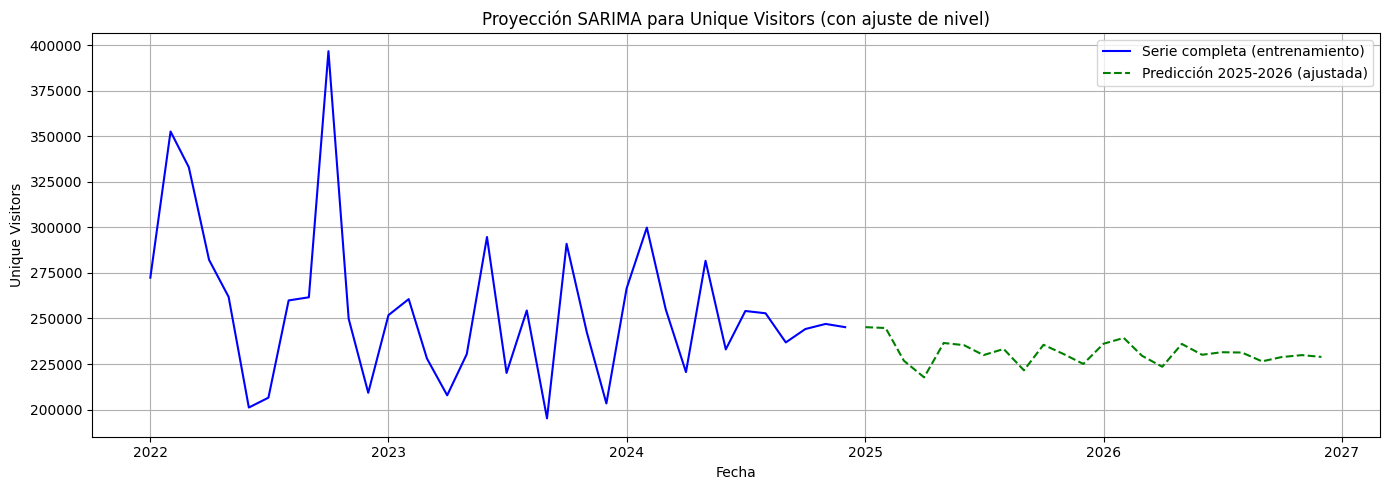

In [22]:
# Suponemos que df_web ya tiene un índice datetime y la columna 'Unique_visitors'
serie_completa = df_web['Unique_visitors']

# ENTRENAR SARIMA CON TODA LA SERIE (usa los hiperparámetros que encontraste antes)
modelo_full = SARIMAX(serie_completa, order=(4, 0, 1), seasonal_order=(1, 0, 2, 12))
sarima_fit_full = modelo_full.fit()

# PREDECIR PARA 2025 Y 2026 (24 meses)
forecast_horizon = 24
pred_2025_2026 = sarima_fit_full.predict(
    start=len(serie_completa),
    end=len(serie_completa) + forecast_horizon - 1,
    typ='levels'
)

# Crear índice de fechas para las predicciones
last_date = serie_completa.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS')
pred_2025_2026.index = future_dates

# OPCIÓN 1: Gráfico sin ajuste
plt.figure(figsize=(14, 5))
plt.plot(serie_completa, label='Serie completa (entrenamiento)', color='blue')
plt.plot(pred_2025_2026, linestyle='--', color='orange', label='Predicción 2025-2026 (sin ajuste)')
plt.title('Proyección SARIMA para Unique Visitors (sin ajuste de nivel)')
plt.xlabel('Fecha')
plt.ylabel('Unique Visitors')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# OPCIÓN 2: Gráfico con ajuste de nivel
ajuste = serie_completa.iloc[-1] - pred_2025_2026.iloc[0]
pred_ajustada = pred_2025_2026 + ajuste

plt.figure(figsize=(14, 5))
plt.plot(serie_completa, label='Serie completa (entrenamiento)', color='blue')
plt.plot(pred_ajustada, linestyle='--', color='green', label='Predicción 2025-2026 (ajustada)')
plt.title('Proyección SARIMA para Unique Visitors (con ajuste de nivel)')
plt.xlabel('Fecha')
plt.ylabel('Unique Visitors')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
# MOSTRAR AIC y BIC
print("AIC del modelo final:", sarima_fit_full.aic)
print("BIC del modelo final:", sarima_fit_full.bic)

AIC del modelo final: 891.4585795496326
BIC del modelo final: 905.7102499957376


A parte del SARIMA que hemos estimado para la variable `Unique_Vistors`, también de cara a la optimización del modelo de atribucción necesitamos también estudiar como se comportarán a futuro las variables que más correlaciondas están con el tráfico_
- `Mercado_off`
- `Direct_traffic`

# Mercado off

## Carga y Preparación Datos

In [57]:
path='../data/raw/offline.csv'
df_off=pd.read_csv(path)
df_off.head()

,ID_Date,Visit_Store,Mercado,Sales,Complementos,Ropa_hombre,Zapatos,Ropa_Mujer,Home,Interior,Otros,Ticket_medio
0,202201,5516,76331,1299,115,270,273,444,131,60,6,68
1,202202,6769,97646,1752,155,393,286,689,179,42,8,86
2,202203,6249,111510,1897,148,442,333,693,249,30,2,92
3,202204,6507,100269,1546,110,371,297,591,154,23,0,87
4,202205,7183,113667,1784,138,411,374,635,187,38,1,83


**Transformaciones Fecha**

In [58]:
# Convertir ID_Date (tipo 202201) en una fecha real: 2022-01-01
df_off['Fecha'] = pd.to_datetime(df_off['ID_Date'].astype(str), format='%Y%m')

# Establecer Fecha como índice y ordenar
df_off.set_index('Fecha', inplace=True)
df_off.sort_index(inplace=True)

# Indicar que es una serie mensual
df_off = df_off.asfreq('MS')

# Para que no salga la hora
df_off.index = df_off.index.to_period('M')

# Eliminar date pq ya lo tenemos como index
df_off.drop('ID_Date',axis=1,inplace=True)


In [59]:
df_off.head()

,Visit_Store,Mercado,Sales,Complementos,Ropa_hombre,Zapatos,Ropa_Mujer,Home,Interior,Otros,Ticket_medio
Fecha,,,,,,,,,,,
2022-01,5516,76331,1299,115,270,273,444,131,60,6,68
2022-02,6769,97646,1752,155,393,286,689,179,42,8,86
2022-03,6249,111510,1897,148,442,333,693,249,30,2,92
2022-04,6507,100269,1546,110,371,297,591,154,23,0,87
2022-05,7183,113667,1784,138,411,374,635,187,38,1,83


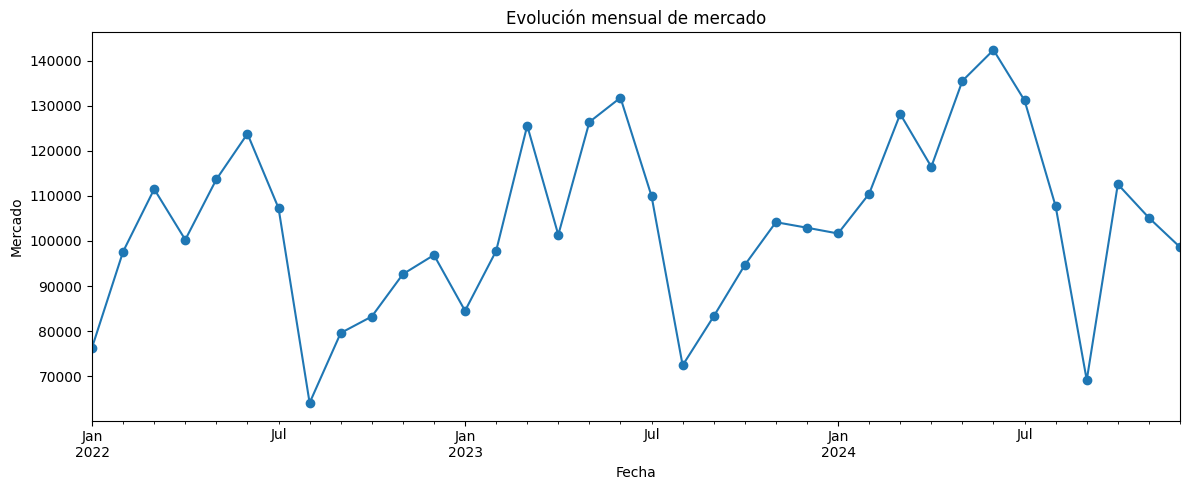

In [60]:
plt.figure(figsize=(12, 5))
df_off['Mercado'].plot(marker='o', linestyle='-')
plt.title('Evolución mensual de mercado')
plt.xlabel('Fecha')
plt.ylabel('Mercado')
plt.tight_layout()
plt.show()

Observaciones clave sobre la serie `Mercado`

- **Picos de mercado**:  
  Se observan valores máximos recurrentes en los meses de mayo a julio, con especial intensidad en mayo y junio de 2024. También destacan subidas notables en marzo y noviembre en distintos años.

- **Caídas pronunciadas**:  
  Hay descensos marcados al finalizar el primer semestre, especialmente en julio y agosto. En agosto de cada año, el valor del mercado suele alcanzar uno de sus puntos más bajos.

- **Estacionalidad**:  
  La serie presenta un comportamiento estacional anual evidente, con ciclos similares cada año. Aumentos en el primer trimestre y decrecimientos en verano son constantes.

- **Tendencia general**:  
  Aunque hay oscilaciones marcadas, la serie no presenta una tendencia clara a largo plazo.

## Serie Mercado

## Descomposición Serie

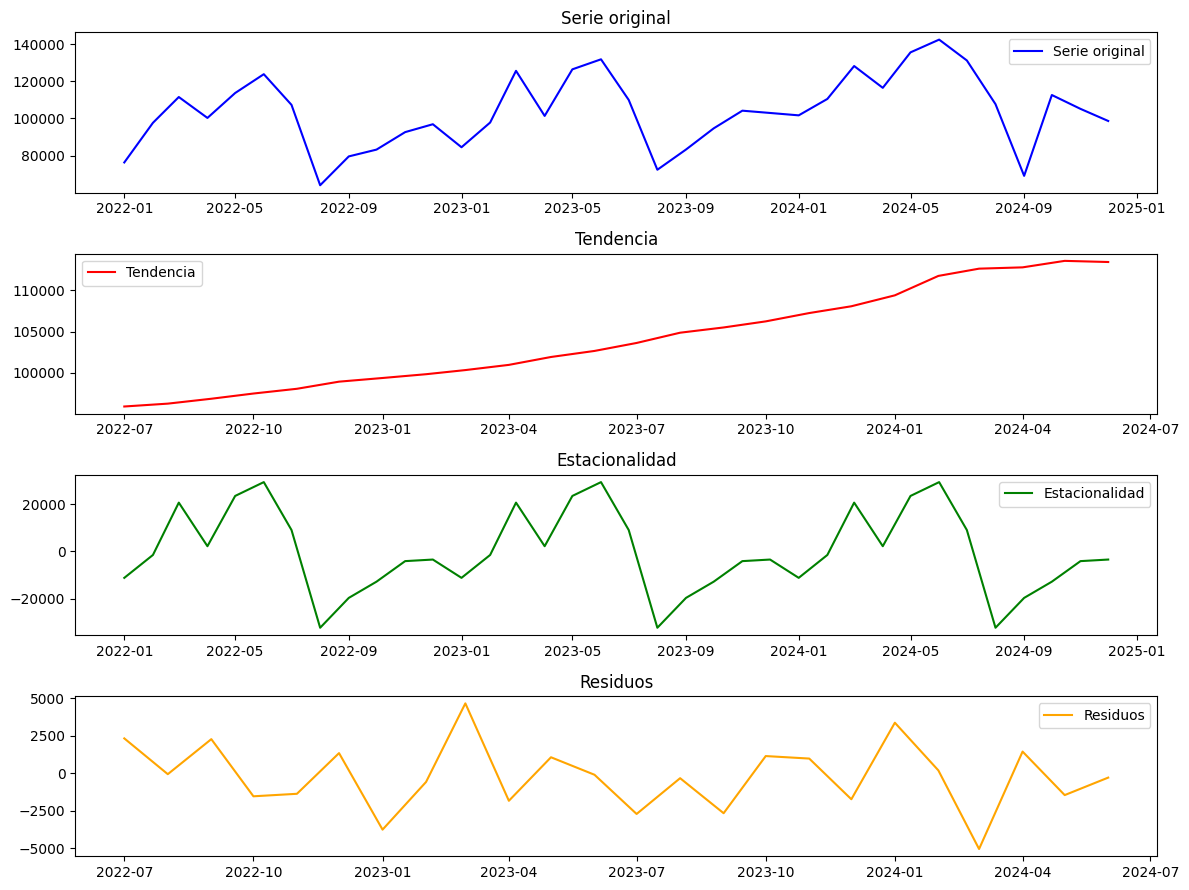

In [61]:
# Serie a analizar
serie = df_off['Mercado']

# Convertir el índice a DatetimeIndex para evitar errores con seasonal_decompose
serie.index = serie.index.to_timestamp()

# Descomposición aditiva con periodo anual (12 meses)
decomposition = seasonal_decompose(serie, model='additive', period=12)

# Componentes
tendencia = decomposition.trend
estacionalidad = decomposition.seasonal
residuos = decomposition.resid

# Gráficas
plt.figure(figsize=(12, 9))

plt.subplot(411)
plt.plot(serie, label='Serie original', color='blue')
plt.title('Serie original')
plt.legend()

plt.subplot(412)
plt.plot(tendencia, label='Tendencia', color='red')
plt.title('Tendencia')
plt.legend()

plt.subplot(413)
plt.plot(estacionalidad, label='Estacionalidad', color='green')
plt.title('Estacionalidad')
plt.legend()

plt.subplot(414)
plt.plot(residuos, label='Residuos', color='orange')
plt.title('Residuos')
plt.legend()

plt.tight_layout()
plt.show()

## Busqueda Coeficientes

In [62]:
serie_temporal = df_off['Mercado']

In [63]:
# División 80/20 para entrenamiento y prueba
train_size = int(len(serie_temporal) * 0.8)
train = serie_temporal[:train_size]
test = serie_temporal[train_size:]


In [64]:
# Ajuste del modelo SARIMA
modelo = auto_arima(train,
                    seasonal=True,
                    m=12,               # Frecuencia mensual
                    start_p=0,
                    start_q=0,
                    start_P=0,
                    start_Q=0,
                    d=1,
                    D=1,
                    max_p=3,
                    max_q=3,
                    max_P=2,
                    max_Q=2,
                    max_d=2,
                    max_D=1,
                    max_order=8,
                    stepwise=False,     # Búsqueda exhaustiva
                    trace=True,
                    scoring='mae',
                    suppress_warnings=True)


 ARIMA(0,1,0)(0,1,0)[12]             : AIC=317.093, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=317.280, Time=0.01 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=318.864, Time=0.04 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=320.951, Time=0.01 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=318.953, Time=0.04 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=320.863, Time=0.06 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=319.031, Time=0.05 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=320.918, Time=0.07 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=322.863, Time=0.08 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=326.925, Time=0.01 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=324.746, Time=0.02 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=324.972, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(0,1,1)(2,1,0)[1

# Sarima Mercado

 Métricas del modelo SARIMA (2,1,2)(2,1,0,12):
MSE:  234,326,024.22
MAE:  11,660.78
RMSE: 15,307.71
R²:   0.5219

 AIC del modelo: 304.25975599497576
 BIC del modelo: 309.21610740269125


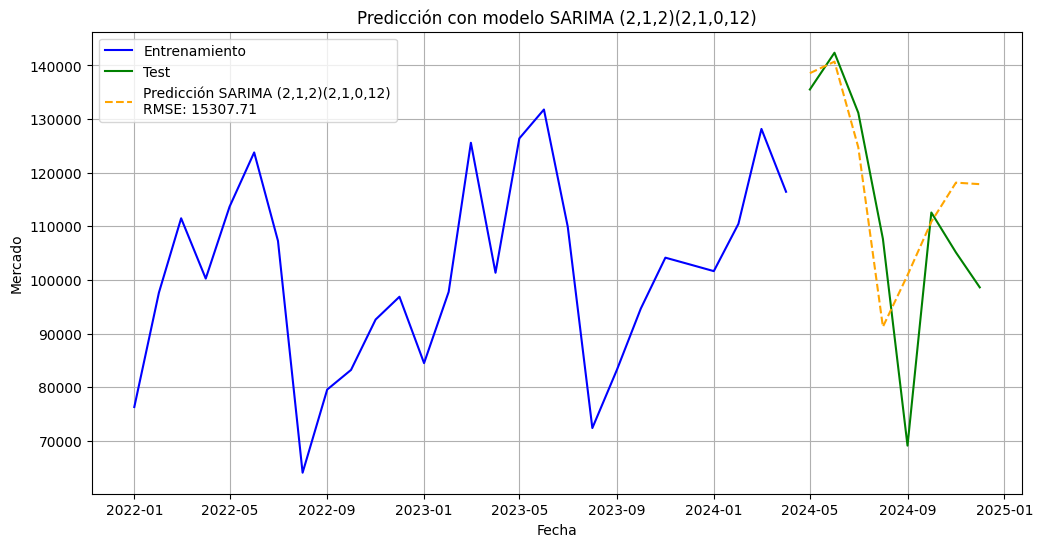

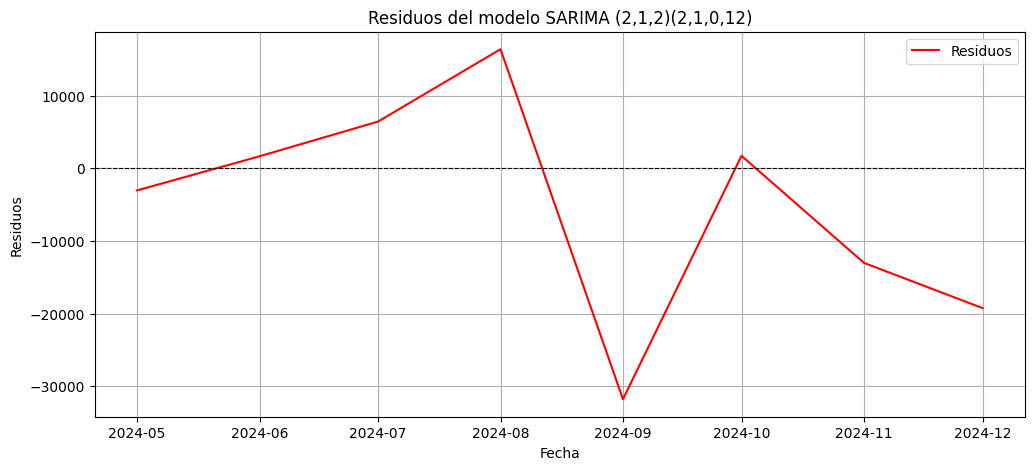

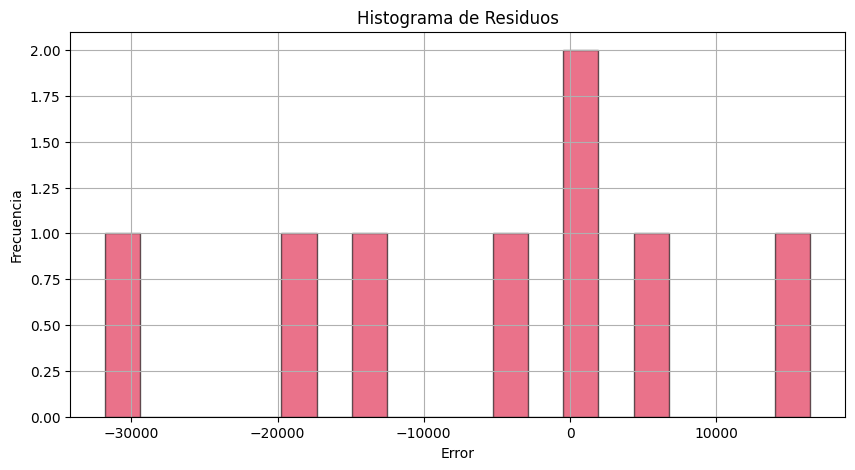


 Coeficientes del modelo SARIMA (2,1,2)(2,1,0,12):
                                      SARIMAX Results                                      
Dep. Variable:                             Mercado   No. Observations:                   28
Model:             SARIMAX(2, 1, 2)x(2, 1, [], 12)   Log Likelihood                -145.130
Date:                             Mon, 14 Apr 2025   AIC                            304.260
Time:                                     08:55:33   BIC                            309.216
Sample:                                 01-01-2022   HQIC                           304.207
                                      - 04-01-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2054      0.220     -5.471      0.000

In [65]:
sarima_model = SARIMAX(train, order=(2, 1, 2), seasonal_order=(2, 1, 0, 12))
sarima_fit = sarima_model.fit()
sarima_predictions = sarima_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

# Calcular métricas
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

metricas = calcular_metricas(test, sarima_predictions)
print(" Métricas del modelo SARIMA (2,1,2)(2,1,0,12):")
print(f"MSE:  {metricas[0]:,.2f}")
print(f"MAE:  {metricas[1]:,.2f}")
print(f"RMSE: {metricas[2]:,.2f}")
print(f"R²:   {metricas[3]:.4f}")

# AIC y BIC
print("\n AIC del modelo:", sarima_fit.aic)
print(" BIC del modelo:", sarima_fit.bic)

# Graficar predicciones
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entrenamiento', color='blue')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(test.index, sarima_predictions, linestyle='--', label=f'Predicción SARIMA (2,1,2)(2,1,0,12)\nRMSE: {metricas[2]:.2f}', color='orange')
plt.xlabel('Fecha')
plt.ylabel('Mercado')
plt.title('Predicción con modelo SARIMA (2,1,2)(2,1,0,12)')
plt.legend()
plt.grid(True)
plt.show()

# Residuos
residuos = test - sarima_predictions

# Gráfico de residuos
plt.figure(figsize=(12, 5))
plt.plot(test.index, residuos, label='Residuos', color='red')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel('Fecha')
plt.ylabel('Residuos')
plt.title('Residuos del modelo SARIMA (2,1,2)(2,1,0,12)')
plt.legend()
plt.grid(True)
plt.show()

# Histograma de residuos
plt.figure(figsize=(10, 5))
plt.hist(residuos, bins=20, color='crimson', edgecolor='black', alpha=0.6)
plt.title('Histograma de Residuos')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Coeficientes del modelo
print("\n Coeficientes del modelo SARIMA (2,1,2)(2,1,0,12):")
print(sarima_fit.summary())  

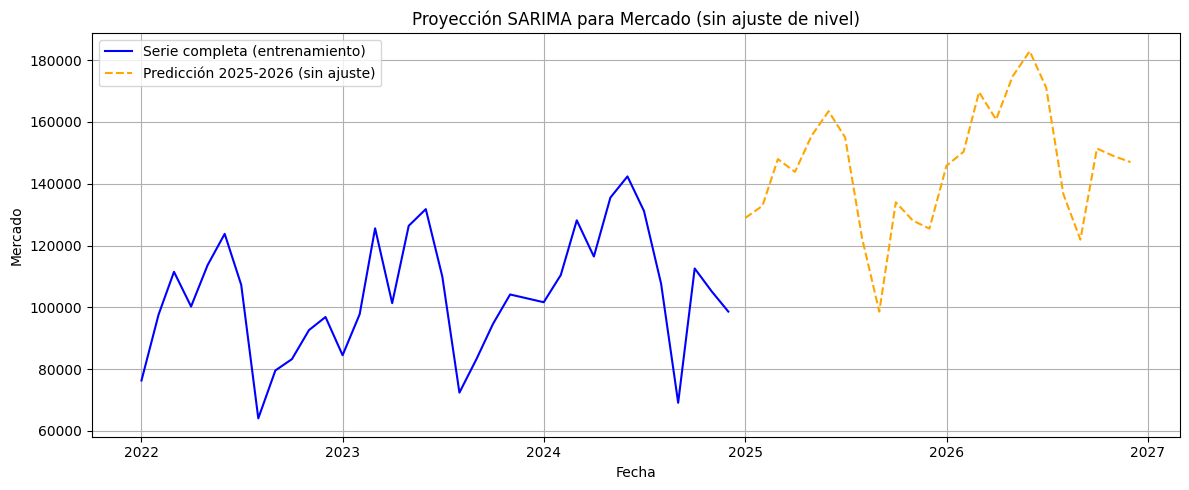

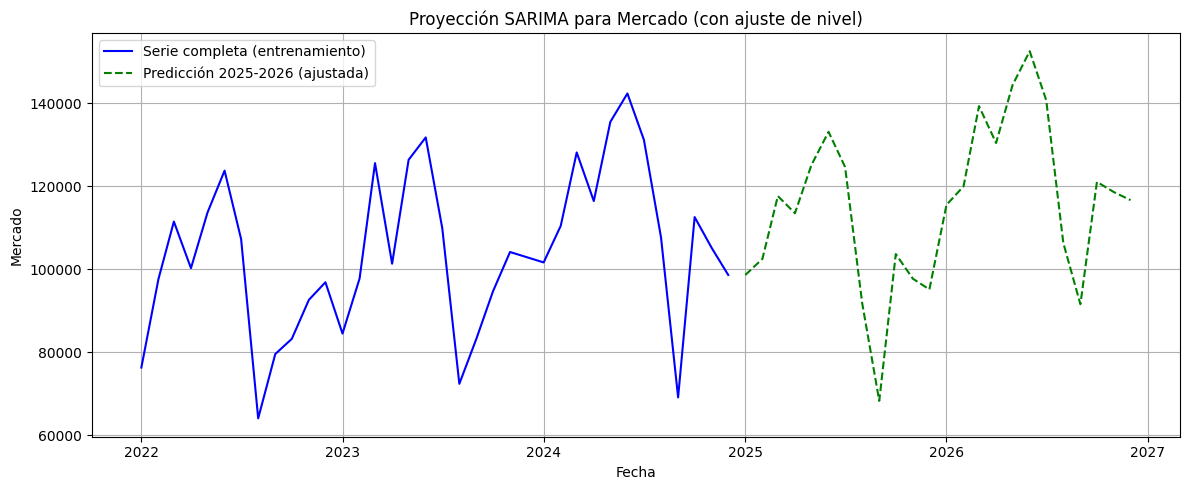

In [66]:
serie_completa = df_off['Mercado']

# ENTRENAR SARIMA CON TODA LA SERIE
modelo_full = SARIMAX(serie_completa, order=(2, 1, 2), seasonal_order=(2, 1, 0, 12))
sarima_fit_full = modelo_full.fit()

# PREDECIR PARA 2025 Y 2026 (24 meses)
forecast_horizon = 24
pred_2025_2026 = sarima_fit_full.predict(
    start=len(serie_completa),
    end=len(serie_completa) + forecast_horizon - 1,
    typ='levels'
)


last_date = serie_completa.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS')
pred_2025_2026.index = future_dates

# OPCIÓN 1: Gráfico sin ajuste
plt.figure(figsize=(12, 5))
plt.plot(serie_completa, label='Serie completa (entrenamiento)', color='blue')
plt.plot(pred_2025_2026, linestyle='--', color='orange', label='Predicción 2025-2026 (sin ajuste)')
plt.title('Proyección SARIMA para Mercado (sin ajuste de nivel)')
plt.xlabel('Fecha')
plt.ylabel('Mercado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# OPCIÓN 2: Gráfico con ajuste de nivel
ajuste = serie_completa.iloc[-1] - pred_2025_2026.iloc[0]
pred_ajustada = pred_2025_2026 + ajuste

plt.figure(figsize=(12, 5))
plt.plot(serie_completa, label='Serie completa (entrenamiento)', color='blue')
plt.plot(pred_ajustada, linestyle='--', color='green', label='Predicción 2025-2026 (ajustada)')
plt.title('Proyección SARIMA para Mercado (con ajuste de nivel)')
plt.xlabel('Fecha')
plt.ylabel('Mercado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Direct Traffic Web

In [67]:
path='../data/raw/web.csv'
df_off=pd.read_csv(path)
df_off.head()

,ID_Date,Unique_visitors,PDFBrochuresDownloaded,ProductConfigurator,Product_configurator_Visists,SocialNetworks,DirectTraffic,EMail,NaturalSearch,OnlineMedia,OtherReferrer,PaidSearch
0,202201,272382,4838,33222,94248,1415,65373,25,167199,63649,39808,13798
1,202202,352581,5823,38570,109531,546,77209,26,176733,124861,45543,28656
2,202203,332955,4845,33956,97805,5444,83178,341,173514,104132,43583,15243
3,202204,282169,3711,45949,90689,1184,69335,162,162805,74044,39650,18510
4,202205,261829,9037,48685,92069,8648,70972,210,156011,44196,40472,20031


**Tratamiento fecha**

In [68]:
# Convertir ID_Date (tipo 202201) en una fecha real: 2022-01-01
df_web['Fecha'] = pd.to_datetime(df_web['ID_Date'].astype(str), format='%Y%m')

# Establecer Fecha como índice y ordenar
df_web.set_index('Fecha', inplace=True)
df_web.sort_index(inplace=True)

# Indicar que es una serie mensual
df_web = df_web.asfreq('MS')

# Para que no salga la hora
df_web.index = df_web.index.to_period('M')

# Eliminar date pq ya lo tenemos como index
df_web.drop('ID_Date',axis=1,inplace=True)


In [69]:
df_web.head()

,Unique_visitors,PDFBrochuresDownloaded,ProductConfigurator,Product_configurator_Visists,SocialNetworks,DirectTraffic,EMail,NaturalSearch,OnlineMedia,OtherReferrer,PaidSearch
Fecha,,,,,,,,,,,
2022-01,272382,4838,33222,94248,1415,65373,25,167199,63649,39808,13798
2022-02,352581,5823,38570,109531,546,77209,26,176733,124861,45543,28656
2022-03,332955,4845,33956,97805,5444,83178,341,173514,104132,43583,15243
2022-04,282169,3711,45949,90689,1184,69335,162,162805,74044,39650,18510
2022-05,261829,9037,48685,92069,8648,70972,210,156011,44196,40472,20031


## Descomposción Serie

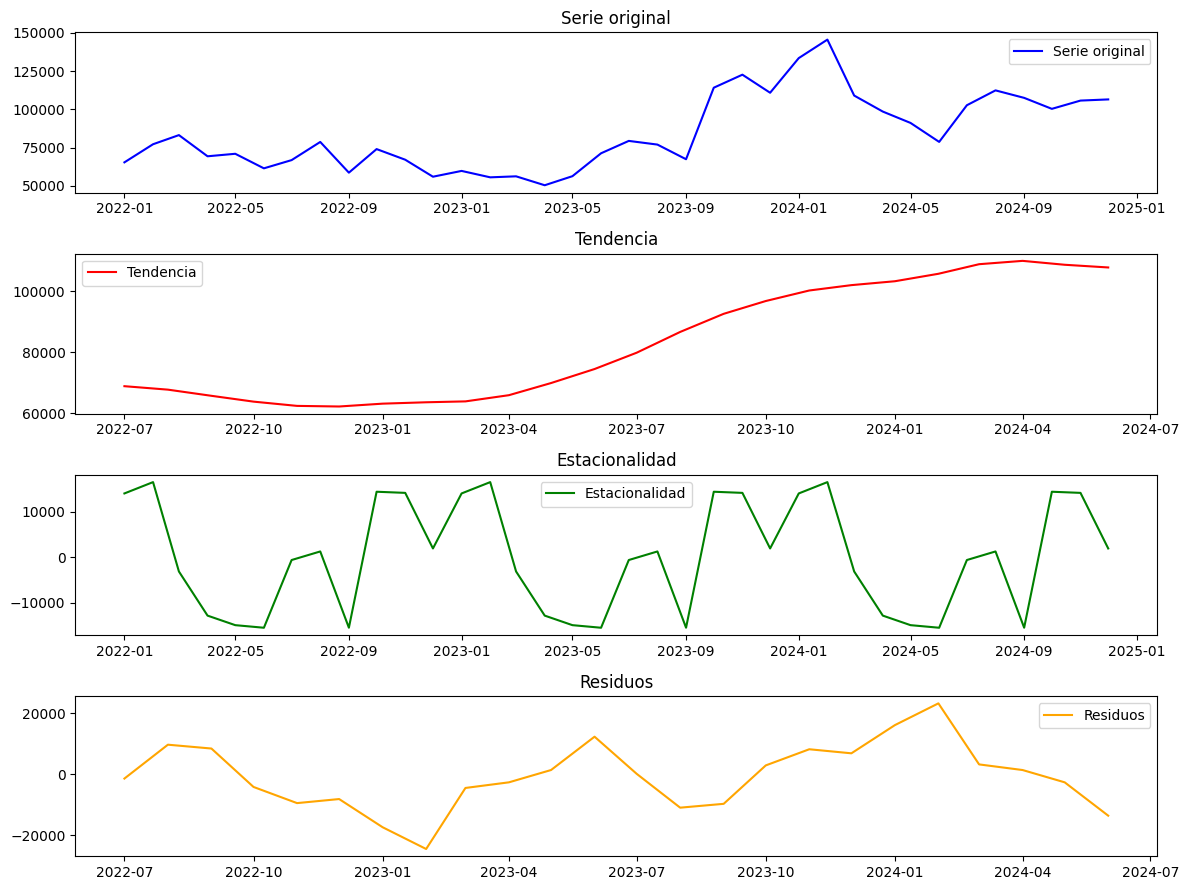

In [70]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Asegurar que el índice es tipo datetime
df_web.index = df_web.index.to_timestamp()

# Serie a analizar (asegúrate de que no tenga valores nulos)
serie = df_web['DirectTraffic'].dropna()

# Descomposición aditiva con periodo anual (12 meses)
decomposition = seasonal_decompose(serie, model='additive', period=12)

# Componentes
tendencia = decomposition.trend
estacionalidad = decomposition.seasonal
residuos = decomposition.resid

# Gráficas
plt.figure(figsize=(12, 9))

plt.subplot(411)
plt.plot(serie, label='Serie original', color='blue')
plt.title('Serie original')
plt.legend()

plt.subplot(412)
plt.plot(tendencia, label='Tendencia', color='red')
plt.title('Tendencia')
plt.legend()

plt.subplot(413)
plt.plot(estacionalidad, label='Estacionalidad', color='green')
plt.title('Estacionalidad')
plt.legend()

plt.subplot(414)
plt.plot(residuos, label='Residuos', color='orange')
plt.title('Residuos')
plt.legend()

plt.tight_layout()
plt.show()

**Observaciones clave sobre la serie `DirectTraffic`**

- **Picos de tráfico directo**  
  Se observan máximos recurrentes hacia el final de cada año, especialmente entre octubre y diciembre. También destacan algunos repuntes a mitad de año, aunque con menor intensidad.

- **Caídas pronunciadas**  
  Hay descensos marcados a inicios de año, especialmente en enero y febrero, y ocasionalmente en los meses centrales como mayo o junio. Esto sugiere un comportamiento cíclico y algo predecible.

- **Estacionalidad**  
  La serie presenta un patrón estacional anual bien definido, con repeticiones claras cada 12 meses. Las oscilaciones entre subidas y bajadas parecen bastante regulares.

- **Tendencia general**  
  Se detecta una tendencia creciente a partir de mediados de 2023, con una evolución positiva sostenida. La parte inicial de la serie era más estable o con ligera caída, pero la segunda mitad muestra un crecimiento progresivo.

## Coefientes Serie

In [71]:
serie_temporal = df_web['DirectTraffic']

# División 80/20
train_size = int(len(serie_temporal) * 0.8)
train = serie_temporal[:train_size]
test = serie_temporal[train_size:]

In [72]:
# Ajuste del modelo SARIMA
modelo = auto_arima(train,
                    seasonal=True,
                    m=12,               # Frecuencia mensual
                    start_p=0,
                    start_q=0,
                    start_P=0,
                    start_Q=0,
                    d=1,
                    D=1,
                    max_p=4,
                    max_q=4,
                    max_P=2,
                    max_Q=2,
                    max_d=2,
                    max_D=1,
                    max_order=8,
                    stepwise=False,     # Búsqueda exhaustiva
                    trace=True,
                    scoring='mae',
                    suppress_warnings=True)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=337.607, Time=0.05 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=337.456, Time=0.02 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=339.396, Time=0.04 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=340.617, Time=0.01 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=339.404, Time=0.02 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=341.395, Time=0.05 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=339.468, Time=0.03 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=341.403, Time=0.04 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=343.392, Time=0.11 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=338.308, Time=0.01 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=339.378, Time=0.02 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=341.371, Time=0.04 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=339.401, Time=0.01 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=341.371, Time=0.03 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=343.370, Time=0.13 sec
 ARIMA(0,1

 Métricas del modelo SARIMA (8,1,03)(2,1,0,12):
MSE:  1,044,786,324.82
MAE:  24,378.95
RMSE: 32,323.15
R²:   -9.1818

 AIC del modelo: 6328.040665639172
 BIC del modelo: 6337.953368454603


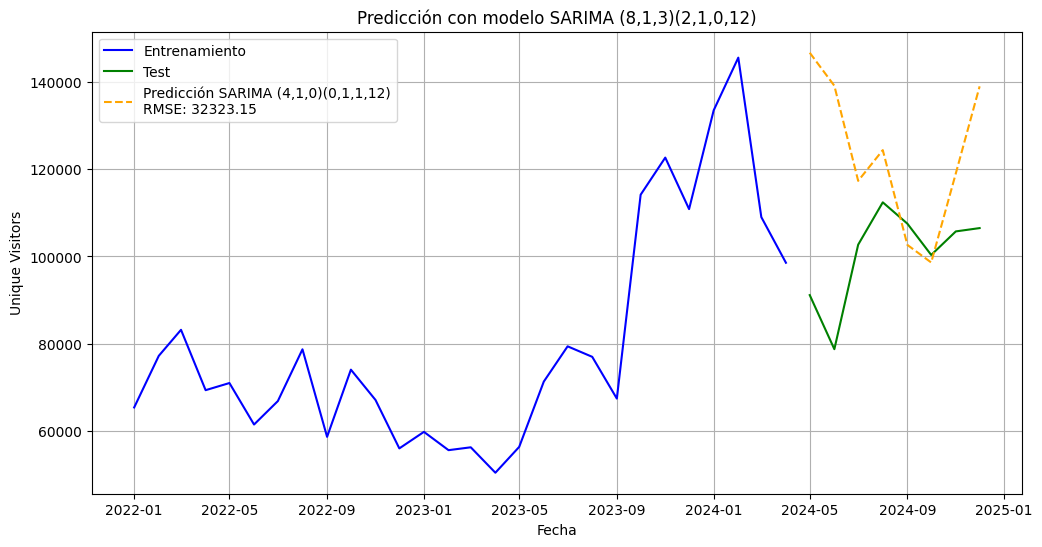

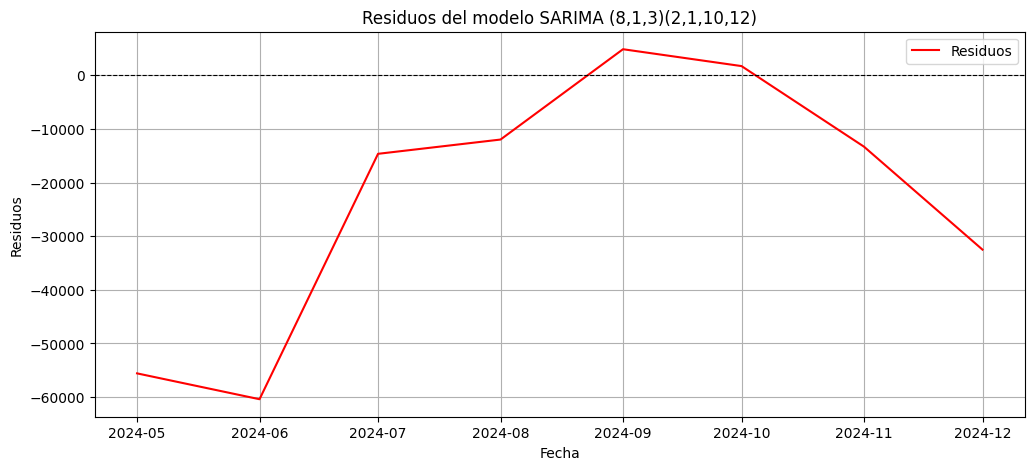

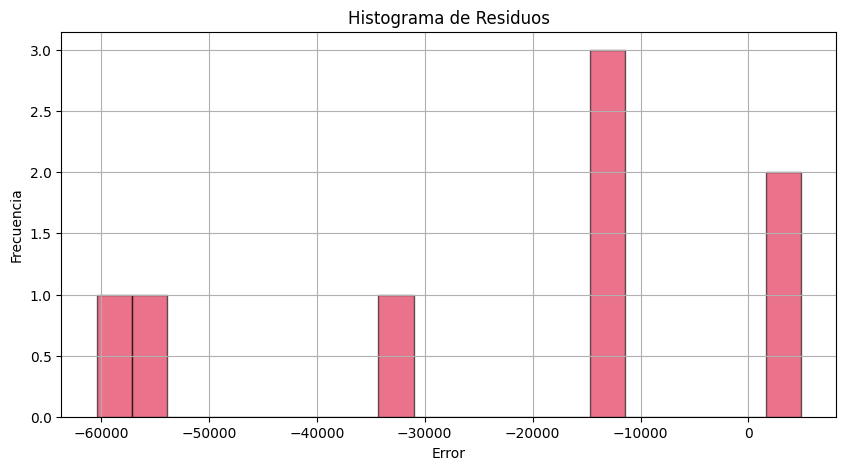


 Coeficientes del modelo SARIMA (8,1,3)(2,1,0,12):
                                      SARIMAX Results                                      
Dep. Variable:                       DirectTraffic   No. Observations:                   28
Model:             SARIMAX(8, 1, 3)x(2, 1, [], 12)   Log Likelihood               -3150.020
Date:                             Mon, 14 Apr 2025   AIC                           6328.041
Time:                                     08:56:03   BIC                           6337.953
Sample:                                 01-01-2022   HQIC                          6327.935
                                      - 04-01-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5748      0.011     52.990      0.000

In [73]:
sarima_model = SARIMAX(train, order=(8, 1, 3), seasonal_order=(2, 1, 0, 12))
sarima_fit = sarima_model.fit()
sarima_predictions = sarima_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

# Calcular métricas
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

metricas = calcular_metricas(test, sarima_predictions)
print(" Métricas del modelo SARIMA (8,1,03)(2,1,0,12):")
print(f"MSE:  {metricas[0]:,.2f}")
print(f"MAE:  {metricas[1]:,.2f}")
print(f"RMSE: {metricas[2]:,.2f}")
print(f"R²:   {metricas[3]:.4f}")

# AIC y BIC
print("\n AIC del modelo:", sarima_fit.aic)
print(" BIC del modelo:", sarima_fit.bic)

# Graficar predicciones
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entrenamiento', color='blue')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(test.index, sarima_predictions, linestyle='--', label=f'Predicción SARIMA (4,1,0)(0,1,1,12)\nRMSE: {metricas[2]:.2f}', color='orange')
plt.xlabel('Fecha')
plt.ylabel('Unique Visitors')
plt.title('Predicción con modelo SARIMA (8,1,3)(2,1,0,12)')
plt.legend()
plt.grid(True)
plt.show()

# Residuos
residuos = test - sarima_predictions

# Gráfico de residuos
plt.figure(figsize=(12, 5))
plt.plot(test.index, residuos, label='Residuos', color='red')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel('Fecha')
plt.ylabel('Residuos')
plt.title('Residuos del modelo SARIMA (8,1,3)(2,1,10,12)')
plt.legend()
plt.grid(True)
plt.show()

# Histograma de residuos
plt.figure(figsize=(10, 5))
plt.hist(residuos, bins=20, color='crimson', edgecolor='black', alpha=0.6)
plt.title('Histograma de Residuos')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Coeficientes del modelo
print("\n Coeficientes del modelo SARIMA (8,1,3)(2,1,0,12):")
print(sarima_fit.summary())